In [1]:
import os
import torch
import torchmetrics
import schnetpack as spk
import schnetpack.transform as trn
from schnetpack.atomistic import Atomwise
from schnetpack.representation import SchNet
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [2]:
go_mol_data = spk.data.AtomsDataModule(
    './coronene_schnet.db',
    batch_size=1,
    distance_unit='Ang',
    property_units={'Spectrum':'eV'},
    num_train=238,
    num_val=29,
    val_batch_size=1,
    transforms=[
        trn.ASENeighborList(cutoff=5.),
        trn.CastTo32()
    ],
    num_workers=1,
    pin_memory=True
)
go_mol_data.prepare_data()
go_mol_data.setup()

In [9]:
properties = go_mol_data.dataset[0]
for prop in properties.keys():
    print(f'{prop} - {properties[prop].shape}')

_idx - torch.Size([1])
Spectrum - torch.Size([1, 200])
_n_atoms - torch.Size([1])
_atomic_numbers - torch.Size([44])
_positions - torch.Size([44, 3])
_cell - torch.Size([1, 3, 3])
_pbc - torch.Size([3])


In [44]:
cutoff = 5.
n_atom_basis = 30

pairwise_distance = spk.atomistic.PairwiseDistances()
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
schnet = SchNet(
    n_atom_basis=n_atom_basis,
    n_interactions=3,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

pred_spectrum = Atomwise(n_in=n_atom_basis, n_out=200, n_hidden=[64, 128, 128],
                        n_layers=3, aggregation_mode='avg', output_key='Spectrum')

In [45]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=[pred_spectrum]
)

In [46]:
output_spec = spk.task.ModelOutput(
    name='Spectrum',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.,
    metrics={'MAE':torchmetrics.MeanAbsoluteError()}
)

In [47]:
task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_spec],
    optimizer_cls=torch.optim.Adam,
    optimizer_args={'lr':1e-4}
)
print(task)

AtomisticTask(
  (model): NeuralNetworkPotential(
    (postprocessors): ModuleList()
    (representation): SchNet(
      (radial_basis): GaussianRBF()
      (cutoff_fn): CosineCutoff()
      (embedding): Embedding(100, 30)
      (electronic_embeddings): ModuleList()
      (interactions): ModuleList(
        (0-2): 3 x SchNetInteraction(
          (in2f): Dense(
            in_features=30, out_features=30, bias=False
            (activation): Identity()
          )
          (f2out): Sequential(
            (0): Dense(in_features=30, out_features=30, bias=True)
            (1): Dense(
              in_features=30, out_features=30, bias=True
              (activation): Identity()
            )
          )
          (filter_network): Sequential(
            (0): Dense(in_features=20, out_features=30, bias=True)
            (1): Dense(
              in_features=30, out_features=30, bias=True
              (activation): Identity()
            )
          )
        )
      )
    )
    (input

In [ ]:
path = './ml_model'
logger = pl.loggers.TensorBoardLogger(save_dir=path)

callbacks = [
    spk.train.ModelCheckpoint(
        model_path=os.path.join(path, 'best_inference_model'),
        save_top_k=1,
        monitor='val_loss'
    )
]

trainer = pl.Trainer(
    callbacks=callbacks,
    logger=logger,
    default_root_dir=path,
    max_epochs=300,
    accelerator='cuda',
    devices=1
)

trainer.fit(task, datamodule=go_mol_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                   | Params | Mode 
-----------------------------------------------------------
0 | model   | NeuralNetworkPotential | 52.1 K | train
1 | outputs | ModuleList             | 0      | train
-----------------------------------------------------------
52.1 K    Trainable params
0         Non-trainable params
52.1 K    Total params
0.208     Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 238/238 [00:05<00:00, 42.55it/s, v_num=3]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 238/238 [00:05<00:00, 43.32it/s, v_num=3, val_loss=0.0132]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 238/238 [00:05<00:00, 42.03it/s, v_num=3, val_loss=0.014] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 238/238 [00:05<00:00, 42.01it/s, v_num=3, val_loss=0.0128]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 238/238 [00:05<00:00, 42.13it/s, v_num=3, val_loss=0.0129]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 238/238 [00:05<00:00, 41.93it/s, v_num=3, val_loss=0.0133]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 238/238 [00:05<00:00, 42.13it/s, v_num=3, val_loss=0.0131]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 238/238 [00:05<00:00, 42.20it/s, v_num=3, val_loss=0.0125]
Validat

In [35]:
best_model = torch.load('./ml_model/best_inference_model', map_location='cpu')

/tmp/ipykernel_10590/1409555684.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./ml_model/best_inference_model', map_location='cpu')


In [39]:
result = []
for batch in tqdm(go_mol_data.test_dataloader()):
    temp = best_model(batch)
    result.append(temp)

100%|██████████| 52/52 [00:00<00:00, 52.94it/s]


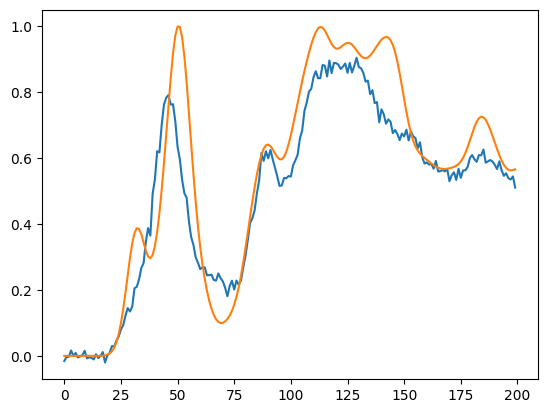

In [43]:
plt.plot(torch.flatten(result[10]['Spectrum']).detach().numpy())
plt.plot(torch.flatten(go_mol_data.test_dataset[10]['Spectrum']).detach().numpy())
plt.show()

In [38]:
from tqdm import tqdm